# Cleaning Exergame SpecParam Model
After testing different model fits with `findBestModel` we will use the best model to parameterize the power spectra of the independent components identified from all Session 1 datasets. This will include using an **error threshold** of `0.103` and an **R^2 threshold** of `0.559` to remove poorly fitted models before our final analysis.

In [1]:
# General Imports to work with files
from scipy import io
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import h5py

# Specparam Functions
from specparam import SpectralGroupModel
from specparam.measures.error import compute_pointwise_error_group

# Custom Functions for Data Import and Cleaning
from cleanmodel_functions import *

In [2]:
# Load and process data (handles both regular and v7.3 formats)
mat_data, format_type = load_matlab_spectra('../results/exergame_session1_PowerSpectrumResults_FILTERED.mat')

if mat_data is None:
    raise ValueError("Failed to load mat file")

# Extract the data using the appropriate format
df = extract_spectra_data(mat_data, format_type)  # Note: now passing format_type

# Close the file if it's h5py to free memory
if format_type == 'h5py':
    mat_data.close()

# Access your spectra data
all_spectra = np.array([spec for spec in df['spectra']])
freqs = np.arange(251)

# Double check shapes
print(f"Frequency arrays shape is {freqs.shape}")
print(f"Spectrum array shape is {all_spectra.shape}")

# Initialize a SpectralGroupModel object, with desired settings
fg = SpectralGroupModel(peak_width_limits=[2, 8], min_peak_height=0.2, peak_threshold=2,
                        max_n_peaks=6, verbose=False)
freq_range = [1, 55]

# Fit the power spectrum model across all components
fg.fit(freqs, all_spectra, freq_range)

# Fit power spectrum models and report on the group
fg.print_results()

File appears to be MATLAB v7.3 format, loading with h5py...
Successfully loaded as HDF5/v7.3 file: ../results/exergame_session1_PowerSpectrumResults_FILTERED.mat
Available variables in .mat file:
  - #refs#: <class 'h5py._hl.group.Group'>
  - results: <class 'h5py._hl.group.Group'>
Results is a structured array (Group)
Available fields in results: ['cluster', 'component', 'experience', 'filename', 'freqs', 'icaact', 'session', 'spectra', 'subject']
Checking field 'subject' with shape: (6040, 1)
Determined 6040 entries from field 'subject'
Processing 6040 entries in results
Processed 500/6040 entries...
Processed 1000/6040 entries...
Processed 1500/6040 entries...
Processed 2000/6040 entries...
Processed 2500/6040 entries...
Processed 3000/6040 entries...
Processed 3500/6040 entries...
Processed 4000/6040 entries...
Processed 4500/6040 entries...
Processed 5000/6040 entries...
Processed 5500/6040 entries...
Processed 6000/6040 entries...

Extracted data summary:
  Total entries: 6040
  

## Flagging and Removing High Error and Underfit Models

In [3]:
# Set quality control thresholds
error_threshold = 0.103
underfit_threshold = 0.559

# Extract indices of models with high error (> 0.103)
error_original_indices = []
for ind, res in enumerate(fg):
    if res.error > error_threshold:
        error_original_indices.append(ind)

print(f"Number of models with Error > {error_threshold}: {len(error_original_indices)}")

# Extract indices of models with low R² (< 0.559)
underfit_original_indices = []
for ind, res in enumerate(fg):
    if res.r_squared < underfit_threshold:
        underfit_original_indices.append(ind)

print(f"Number of models with R² < {underfit_threshold}: {len(underfit_original_indices)}")

# Combine both sets of problematic indices and remove duplicates
bad_model_indices = list(set(error_original_indices + underfit_original_indices))
bad_model_indices.sort()  # Sort for easier inspection

print(f"Total unique models to remove: {len(bad_model_indices)}")
print(f"Original dataframe shape: {df.shape}")

# Create documentation of removed data
if len(bad_model_indices) > 0:
    # Extract information for removed models
    removed_data = df.loc[bad_model_indices, ['subject', 'session', 'experience', 'component', 'cluster']].copy()

    # Add reason for removal for better documentation
    removed_data['removal_reason'] = ''

    # Mark reasons for removal
    for idx in bad_model_indices:
        reasons = []
        if idx in error_original_indices:
            reasons.append(f'high_error(>{error_threshold})')
        if idx in underfit_original_indices:
            reasons.append(f'low_r_squared(<{underfit_threshold})')
        removed_data.loc[idx, 'removal_reason'] = '; '.join(reasons)

    # Add the actual error and r_squared values for reference
    removed_data['error_value'] = [fg[idx].error for idx in bad_model_indices]
    removed_data['r_squared_value'] = [fg[idx].r_squared for idx in bad_model_indices]

    # Reset index to make it cleaner
    removed_data = removed_data.reset_index().rename(columns={'index': 'original_df_index'})

    # Export to CSV
    removed_data.to_csv('../results/specparam/final_model/removed_models_log.csv', index=False)
    print(f"Removed data documentation saved to 'removed_models_log.csv'")
    print(f"Removed data preview:")
    print(removed_data.head())
else:
    print("No models were removed - no documentation file created.")

# Remove rows corresponding to bad models from the dataframe
# Using drop with index labels
df_cleaned = df.drop(index=bad_model_indices).reset_index(drop=True)

print(f"Cleaned dataframe shape: {df_cleaned.shape}")
print(f"Removed {df.shape[0] - df_cleaned.shape[0]} rows from dataframe")

# Verify the cleaning worked
print(f"\nData quality summary:")
print(f"- Models with high error removed: {len(error_original_indices)}")
print(f"- Models with low R² removed: {len(underfit_original_indices)}")
print(f"- Total models removed: {len(bad_model_indices)}")
print(f"- Models retained: {len(df_cleaned)}")

Number of models with Error > 0.103: 83
Number of models with R² < 0.559: 153
Total unique models to remove: 209
Original dataframe shape: (6040, 9)
Removed data documentation saved to 'removed_models_log.csv'
Removed data preview:
   original_df_index  subject session   experience  component  cluster  \
0                196  exgm057      s1   shoulder_1          1       10   
1                291  exgm107      s1  prebaseline         22       10   
2                292  exgm107      s1   shoulder_1         22       10   
3                293  exgm107      s1   shoulder_2         22       10   
4                294  exgm107      s1   shoulder_3         22       10   

          removal_reason  error_value  r_squared_value  
0  low_r_squared(<0.559)     0.072053         0.540163  
1  low_r_squared(<0.559)     0.020829         0.523017  
2  low_r_squared(<0.559)     0.054308         0.356250  
3  low_r_squared(<0.559)     0.062718         0.128151  
4  low_r_squared(<0.559)     0.049672 

## Running SpecParam on Cleaner Model

                                                                                                  
                                          GROUP RESULTS                                           
                                                                                                  
                            Number of power spectra in the Group: 5831                            
                                                                                                  
                        The model was run on the frequency range 1 - 55 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                              
                                                                                                  
          

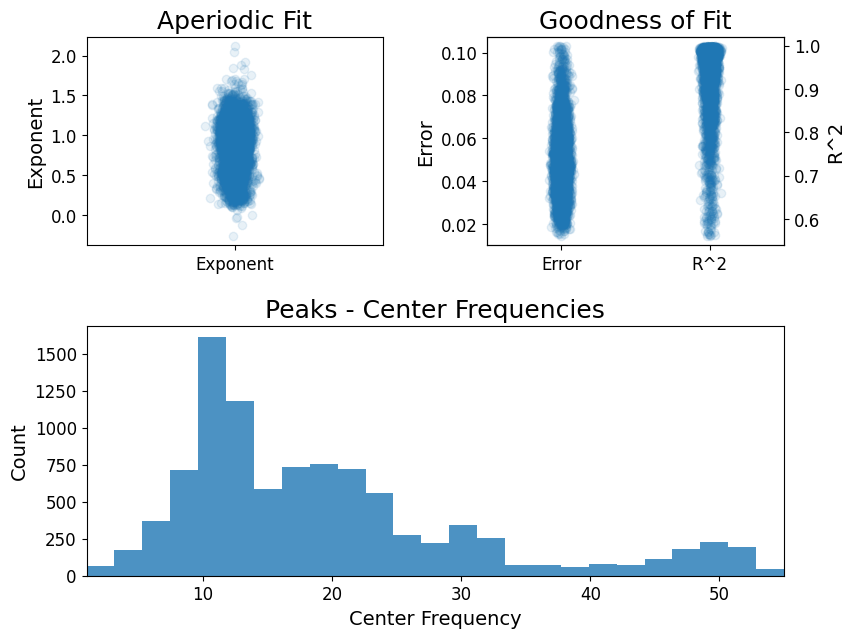

In [4]:
cleaned_spectra = np.array([spec for spec in df_cleaned['spectra']])
# Initialize and fit new SpectralGroupModel on cleaned data
fg_cleaned = SpectralGroupModel(peak_width_limits=[2, 8], min_peak_height=0.2, peak_threshold=2,
                               max_n_peaks=6, verbose=False)
fg_cleaned.fit(freqs, cleaned_spectra, freq_range)

# Fit power spectrum models and report on the group
fg_cleaned.print_results()
fg_cleaned.plot()

# Check the overall results of the group fits and save as PDF
fg_cleaned.save_report(f"../results/specparam/final_model/GroupReportAfterThresholding")

## Removing Negative Exponent Models
It's highly unlikely for a power spectral model to have a negative exponent given its expected 1/f nature. So, we'll skim through the new model's fit spectra and remove any spectra with a negative exponent.

Because the exponent is a part of the aperiodic parameters of the spectral model, we'll need to access it through `res.aperiodic_params`. Note that it is the second value in the array. The first value is the offset.

In [5]:
# Extract models with negative exponents
# The exponent is the second value in aperiodic_params (index 1)
negative_exponent_indices = []
for ind, res in enumerate(fg_cleaned):
    if res.aperiodic_params[1] < 0:  # exponent is negative
        negative_exponent_indices.append(ind)

print(f"\nNumber of models with negative exponents: {len(negative_exponent_indices)}")

# Create documentation of models with negative exponents
if len(negative_exponent_indices) > 0:
    # Extract information for models with negative exponents
    negative_exp_data = df_cleaned.iloc[negative_exponent_indices][['subject', 'session', 'experience', 'component', 'cluster']].copy()

    # Add removal reason and exponent values for documentation
    negative_exp_data['removal_reason'] = 'negative_exponent'
    negative_exp_data['exponent_value'] = [fg_cleaned[idx].aperiodic_params[1] for idx in negative_exponent_indices]

    # Add original indices from df_cleaned for traceability
    negative_exp_data = negative_exp_data.reset_index().rename(columns={'index': 'df_cleaned_index'})

    # Add filename for cross-reference with saved plots
    negative_exp_data['plot_filename'] = negative_exp_data.apply(
        lambda row: f"{row['subject']}_{row['session']}_{row['experience']}_IC{row['component']}_Cluster{row['cluster']}.png",
        axis=1
    )

    # Export to CSV
    negative_exp_data.to_csv('../results/specparam/final_model/negative_exponent_models_log.csv', index=False)
    print(f"Negative exponent models documentation saved to 'negative_exponent_models_log.csv'")
    print(f"Negative exponent data preview:")
    print(negative_exp_data.head())
else:
    print("No models with negative exponents found - no documentation file created.")

# Create directory for negative exponent models
negative_exp_dir = "../results/specparam/final_model/negativeExponents/"
os.makedirs(negative_exp_dir, exist_ok=True)

# Plot and save models with negative exponents
for i, model_ind in enumerate(negative_exponent_indices):
    # Get the model from fg_cleaned
    fm = fg_cleaned.get_model(model_ind, regenerate=True)

    # Extract subject, session, experience, and component from df_cleaned using the index
    subject = df_cleaned.iloc[model_ind]['subject']
    session = df_cleaned.iloc[model_ind]['session']
    experience = df_cleaned.iloc[model_ind]['experience']
    component = df_cleaned.iloc[model_ind]['component']
    cluster = df_cleaned.iloc[model_ind]['cluster']

    # Create the plot
    fig = fm.plot()

    # Create filename with extracted information
    filename = f"{subject}_{session}_{experience}_IC{component}_Cluster{cluster}.png"

    # Save the figure
    plt.savefig(f"{negative_exp_dir}/{filename}", dpi=300, bbox_inches='tight')

    # Close the figure to free memory
    plt.close(fig)

print(f"All {len(negative_exponent_indices)} negative exponent models saved to: {negative_exp_dir}")

# Remove models with negative exponents from df_cleaned to create df_final
df_final = df_cleaned.drop(index=df_cleaned.index[negative_exponent_indices]).reset_index(drop=True)

print(f"\nFinal data summary:")
print(f"- df_cleaned shape: {df_cleaned.shape}")
print(f"- Models with negative exponents removed: {len(negative_exponent_indices)}")
print(f"- df_final shape: {df_final.shape}")
print(f"- Total models removed from original data: {df.shape[0] - df_final.shape[0]}")


Number of models with negative exponents: 5
Negative exponent models documentation saved to 'negative_exponent_models_log.csv'
Negative exponent data preview:
   df_cleaned_index  subject session  experience  component  cluster  \
0              2353  exgm164      s1    tandem_1         20       13   
1              2434  exgm185      s1  shoulder_2          8       13   
2              4323  exgm136      s1    tandem_3          9        6   
3              4658  exgm111      s1  shoulder_1         12        7   
4              4659  exgm111      s1  shoulder_2         12        7   

      removal_reason  exponent_value                            plot_filename  
0  negative_exponent       -0.029811   exgm164_s1_tandem_1_IC20_Cluster13.png  
1  negative_exponent       -0.000808  exgm185_s1_shoulder_2_IC8_Cluster13.png  
2  negative_exponent       -0.259980     exgm136_s1_tandem_3_IC9_Cluster6.png  
3  negative_exponent       -0.131338  exgm111_s1_shoulder_1_IC12_Cluster7.png  
4  nega

## Run final dataframe through SpecParam, save outputs for analysis on separate script

                                                                                                  
                                          GROUP RESULTS                                           
                                                                                                  
                            Number of power spectra in the Group: 5826                            
                                                                                                  
                        The model was run on the frequency range 1 - 55 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                              
                                                                                                  
          

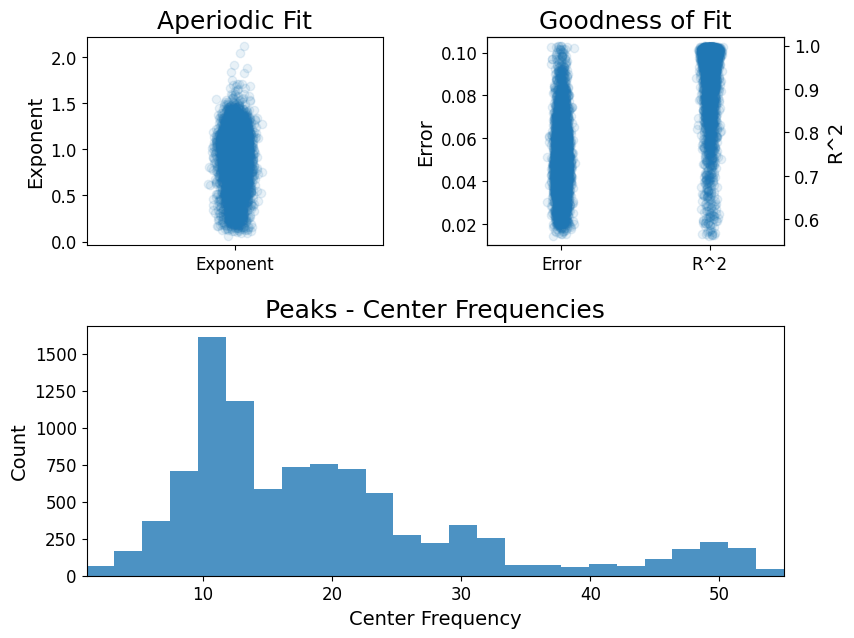

In [6]:
# Extract spectra from final dataframe
final_spectra = np.array([spec for spec in df_final['spectra']])
# Initialize and fit new SpectralGroupModel on cleaned data
fg_final = SpectralGroupModel(peak_width_limits=[2, 8], min_peak_height=0.2, peak_threshold=2,
                               max_n_peaks=6, verbose=False)
fg_final.fit(freqs, final_spectra, freq_range)

# Fit power spectrum models and report on the group
fg_final.print_results()
fg_final.plot()

# Check the overall results of the group fits and save as PDF
fg_final.save_report(f"../results/specparam/final_model/FinalGroupReport")

# Save final dataframe for thorough analysis
df_final.to_pickle('../results/specparam/final_model/df_final.pkl')